In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
import pdb

print("tf version", tf. __version__)

2023-07-06 11:21:36.666825: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 11:21:36.669380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 11:21:36.719190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 11:21:36.720254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 11:21:37.824016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

tf version 2.12.0


In [2]:
# Set the working directory
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [3]:
# Set seed
seed = 42
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  # tf.experimental.numpy.random.seed(seed)
  # tf.compat.v1.get_seed(seed)
  # tf.compat.v1.set_random_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['CUDA_VISIBLE_DEVICES'] = " "
set_seed(42)

# from keras import backend as K
# session_conf = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)
# #Force Tensorflow to use a single thread
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

tf.config.experimental.enable_op_determinism()

In [6]:
# Load dataset
csv_path = os.getcwd() + '/SOC600to1400.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df = df.drop(columns=['latitude', 'longitude', 'year', 'LC', 'site', 'siteid'])
df['temp'] = df['temp']*0.02
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,VV,VH,VV/VH,prec,temp
0,12.3442,1241,0.0,208.339081,3.538936,1.673863,0.299345,0.318458,0.313535,0.47573,0.323572,0.266317,0.158519,0.087021,0.027682,3.143623,11.357198,307.367368
1,12.3442,1241,0.0,208.339081,3.538936,1.673863,0.323682,0.350743,0.341915,0.50521,0.262082,0.237772,0.332121,0.089803,0.025089,3.579326,10.001375,309.193679
2,12.3442,1241,0.0,208.339081,3.538936,1.673863,0.272285,0.303731,0.317302,0.470313,0.215443,0.214301,0.264617,0.113608,0.024506,4.63591,13.207593,305.738129
3,12.3442,1241,0.0,208.339081,3.538936,1.673863,0.07709,0.133933,0.156812,0.230595,0.243795,0.200153,0.108398,0.050267,0.010047,5.003065,8.30924,310.411518
4,12.3442,1241,0.0,208.339081,3.538936,1.673863,0.135472,0.17367,0.194433,0.32657,0.28422,0.236865,0.16665,0.049323,0.010233,4.819805,7.434655,309.301705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3975,7.91165,933,3.818729,58.208199,11.131647,-0.021206,0.193016,0.233854,0.258783,0.339564,0.315433,0.242668,0.152299,0.117782,0.032872,3.583099,5.681763,313.016135
3976,7.91165,933,3.818729,58.208199,11.131647,-0.021206,0.165942,0.212431,0.243438,0.334408,0.3005,0.258398,0.13589,0.132094,0.037693,3.504499,7.638311,311.110654
3977,7.91165,933,3.818729,58.208199,11.131647,-0.021206,0.739592,0.708847,0.709013,0.735962,0.23703,0.244647,0.197731,0.119991,0.03305,3.63056,6.670352,311.589897
3978,7.91165,933,3.818729,58.208199,11.131647,-0.021206,0.10107,0.160607,0.172928,0.325195,0.231008,0.20843,0.230066,0.128847,0.03729,3.45525,9.09449,308.674743


In [63]:
# Shuffle and scale the data
# df = df.sample(frac=1, random_state=42)
scaler = MinMaxScaler()
n = len(df)

# train_df = scaler.fit_transform(df[0:int(n*0.8)])
# val_df = scaler.transform(df[int(n*0.8):int(n*0.9)])
# test_df = scaler.transform(df[int(n*0.9):])
train_df = scaler.fit_transform(df[:3185])
val_df = scaler.transform(df[3185:3500])
test_df = scaler.transform(df[3500:])
max = np.max(df[:3185].SOC)
min = np.min(df[:3185].SOC)

Xtrain = train_df[:,1:]
Ytrain = train_df[:,0]
# [::5]

Xval = val_df[:,1:]
Yval = val_df[:,0]
# [::5]

Xtest = test_df[:,1:]
Ytest = test_df[:,0]
# [::5]

# Reshape it to be (n_data, time_step, feature)
Xtrain = np.reshape(Xtrain, (int(Xtrain.shape[0]/5), 5, Xtrain.shape[1]))
Xval = np.reshape(Xval, (int(Xval.shape[0]/5), 5, Xval.shape[1]))
Xtest = np.reshape(Xtest, (int(Xtest.shape[0]/5), 5, Xtest.shape[1]))

# Reshape it to be (n_data, time_step)
Ytrain = np.reshape(Ytrain, (int(Ytrain.shape[0]/5), 5))
Yval = np.reshape(Yval, (int(Yval.shape[0]/5), 5))
Ytest = np.reshape(Ytest, (int(Ytest.shape[0]/5),5))

In [24]:
# Show metadsata of the dataset
df.apply(['mean', 'median', 'max', 'min', 'std', 'skew', 'count']).transpose()

,mean,median,max,min,std,skew,count
SOC,10.841766,8.088325,91.416900,2.118900,10.584258,3.851447,3980.0
elev,832.179648,956.000000,2004.000000,0.000000,512.121498,-0.245717,3980.0
slope,4.931380,2.844062,42.718117,0.000000,6.396783,2.785089,3980.0
aspect,177.230573,173.564682,359.977112,0.032219,108.925980,0.079549,3980.0
roughness,14.454138,5.205354,157.365005,0.288789,23.881823,2.917422,3980.0
twi,0.420232,0.048702,9.095262,-3.766251,2.138266,1.227431,3980.0
SR_B2,0.237874,0.189263,0.969795,0.002620,0.179156,0.956346,3980.0
SR_B3,0.278858,0.240419,0.963333,0.033406,0.153769,0.942502,3980.0
SR_B4,0.295413,0.262282,0.958135,0.028222,0.151137,0.855335,3980.0
SR_B5,0.432829,0.419327,0.934045,0.095735,0.113961,0.598727,3980.0


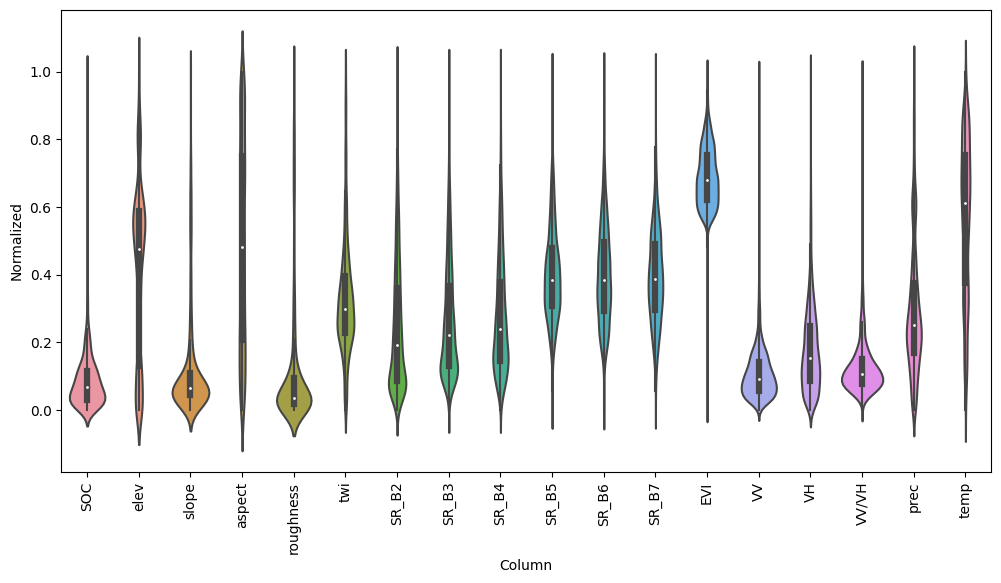

In [25]:
# Show the value ranes of the dataset
df_std = pd.DataFrame(train_df).melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [97]:
# Hyperparameter tuning using validation dataset
# initializer = tf.keras.initializers.GlorotUniform(seed=42)
batch_size = [128, 256]
units = [32, 64, 128, 256]
units_dense = 1
lr = [0.05, 0.01, 0.005]
epochs = 200
info = pd.DataFrame(columns=['batchsize', 'unit', 'learningrate', 'model', 'rmse', 'r2'])
i = 0

for batchSize in batch_size:
    for unit in units:
        for learningRate in lr:

            model1 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2])),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])
            
            model2 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])

            model3 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/4), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')
            ])

            model4 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/4), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/8), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')
            ])
            
            for j in range(4):
                model = [model1, model2, model3, model4][j]
                
                print(i)

                model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
                    metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                            tf.keras.metrics.RootMeanSquaredError()
                            ])

                # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
                early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

                history = model.fit(Xtrain, Ytrain, 
                                    epochs=epochs, 
                                    batch_size=batchSize,
                                    validation_data=(Xval, Yval), 
                                    callbacks=[early_stopping]
                                    )
                
                Ypred = model.predict(Xval)
                Yval = np.array([sublist[::5] for sublist in Yval])
                Ypred = Ypred * (max-min) + min
                Yval = Yval * (max-min) + min

                mse = mean_squared_error(Yval, Ypred)
                print("RMSE", math.sqrt(mse))
                mae = mean_absolute_error(Yval, Ypred)
                print("MAE", mae)
                R_square = r2_score(Yval, Ypred) 
                print('Coefficient of Determination', R_square) 

                addCol = pd.Series( [ batchSize, unit, learningRate, str(j+1), math.sqrt(mse), R_square ],
                       index=info.columns 
                       )
                
                info.loc[i] = addCol

                i=i+1

print(info)
info.to_csv(os.getcwd() + '/info.csv', index=False)

2023-07-06 12:16:48.681407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 12:16:48.683967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 12:16:48.685450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

0
Epoch 1/200


2023-07-06 12:16:50.944462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 12:16:50.946519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 12:16:50.947838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/5 [=====>........................] - ETA: 8s - loss: 1.2642 - mean_absolute_error: 0.8827 - root_mean_squared_error: 1.1244

2023-07-06 12:16:53.379978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [63,5]
	 [[{{node Placeholder/_11}}]]
2023-07-06 12:16:53.380340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [63,5]
	 [[{{node Placeholder/_11}}]]
2023-07-06 12:16:53.633087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

5/5 [==============================] - 3s 175ms/step - loss: 2.3708 - mean_absolute_error: 1.0542 - root_mean_squared_error: 1.5398 - val_loss: 0.0384 - val_mean_absolute_error: 0.1616 - val_root_mean_squared_error: 0.1960
Epoch 2/200
5/5 [==============================] - 0s 25ms/step - loss: 0.2493 - mean_absolute_error: 0.3527 - root_mean_squared_error: 0.4993 - val_loss: 0.0075 - val_mean_absolute_error: 0.0527 - val_root_mean_squared_error: 0.0868
Epoch 3/200
5/5 [==============================] - 0s 23ms/step - loss: 0.1058 - mean_absolute_error: 0.2387 - root_mean_squared_error: 0.3252 - val_loss: 0.0164 - val_mean_absolute_error: 0.0936 - val_root_mean_squared_error: 0.1280
Epoch 4/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0587 - mean_absolute_error: 0.1826 - root_mean_squared_error: 0.2423 - val_loss: 0.0087 - val_mean_absolute_error: 0.0629 - val_root_mean_squared_error: 0.0931
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0

In [95]:
model2 = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(unit, input_shape=(None, Xtrain.shape[2]), return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.LSTM(int(unit/2), return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2, seed=seed),
                tf.keras.layers.Dense(units_dense, activation='linear')])

2023-07-06 12:14:03.635243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 12:14:03.637721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 12:14:03.640161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [96]:
# Define the potential best model and its hyperparameters
batch_size = 128
unit = 64
units_dense = 1
lr = 0.01
epochs = 200
model = model2

In [36]:
# See the model details
print('train data size', len(train_df))
model.summary()

train data size 3185
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          20992     
                                                                 
 batch_normalization (BatchN  (None, None, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None,

In [39]:
# Train the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                       tf.keras.metrics.RootMeanSquaredError()
                       ])

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM', update_freq='epoch', profile_batch=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(Xtrain, Ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(Xval, Yval), 
                    callbacks=[early_stopping]
                    )

Epoch 1/200


2023-07-06 11:43:40.225265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [637,5]
	 [[{{node Placeholder/_11}}]]
2023-07-06 11:43:40.225617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [637,5]
	 [[{{node Placeholder/_11}}]]
2023-07-06 11:43:40.502771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

4/5 [=======================>......] - ETA: 0s - loss: 0.7100 - mean_absolute_error: 0.6504 - root_mean_squared_error: 0.8426 

2023-07-06 11:43:44.969948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [63,5]
	 [[{{node Placeholder/_11}}]]
2023-07-06 11:43:44.970328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [63,5]
	 [[{{node Placeholder/_11}}]]
2023-07-06 11:43:45.280665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

5/5 [==============================] - 6s 309ms/step - loss: 0.6759 - mean_absolute_error: 0.6350 - root_mean_squared_error: 0.8221 - val_loss: 0.0087 - val_mean_absolute_error: 0.0747 - val_root_mean_squared_error: 0.0935
Epoch 2/200
5/5 [==============================] - 0s 37ms/step - loss: 0.4009 - mean_absolute_error: 0.4914 - root_mean_squared_error: 0.6331 - val_loss: 0.0188 - val_mean_absolute_error: 0.1255 - val_root_mean_squared_error: 0.1371
Epoch 3/200
5/5 [==============================] - 0s 37ms/step - loss: 0.2602 - mean_absolute_error: 0.3980 - root_mean_squared_error: 0.5101 - val_loss: 0.0139 - val_mean_absolute_error: 0.0998 - val_root_mean_squared_error: 0.1181
Epoch 4/200
5/5 [==============================] - 0s 36ms/step - loss: 0.1653 - mean_absolute_error: 0.3212 - root_mean_squared_error: 0.4066 - val_loss: 0.0090 - val_mean_absolute_error: 0.0758 - val_root_mean_squared_error: 0.0948
Epoch 5/200
5/5 [==============================] - 0s 37ms/step - loss: 0.1

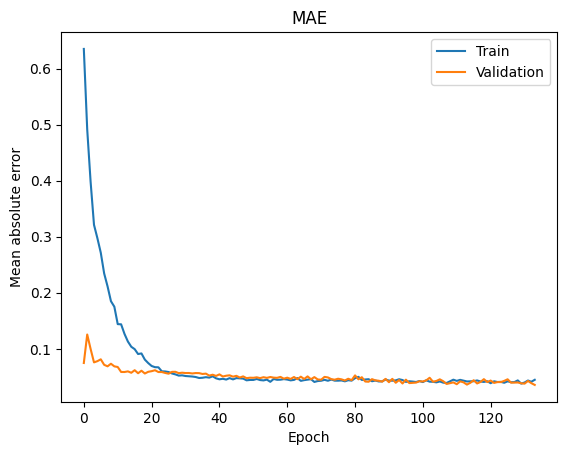

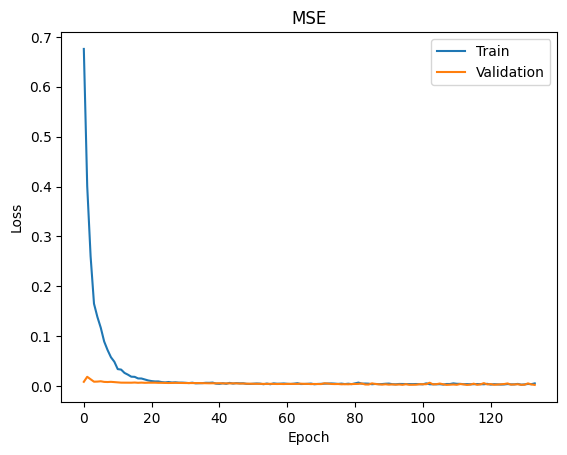

In [40]:
# Plot the training and validation accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [86]:
# Predict SOC using test dataset
Ypred = model.predict(Xtest)
Ytest = np.array([sublist[::5] for sublist in Ytest])
Ypred = Ypred * (max-min) + min
Ytest = Ytest * (max-min) + min
print('shape', Ypred.shape)
print(Ypred[:10], np.max(Ypred), np.min(Ypred))

3/3 [==============================] - 0s 6ms/step
shape (96, 1)
[[ 8.98865  ]
 [11.488022 ]
 [10.53924  ]
 [10.548157 ]
 [ 8.28095  ]
 [11.268655 ]
 [46.48499  ]
 [ 6.855706 ]
 [ 6.3408804]
 [ 9.762946 ]] 48.59039 3.6798005


2023-07-06 12:06:40.110596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [96,5,17]
	 [[{{node Placeholder/_10}}]]
2023-07-06 12:06:40.111023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [96,5,17]
	 [[{{node Placeholder/_10}}]]


In [87]:
# Calculate the metric values
mse = mean_squared_error(Ytest, Ypred)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ytest, Ypred)
print("MAE", mae)
R_square = r2_score(Ytest, Ypred) 
print('Coefficient of Determination', R_square) 

RMSE 8.142400911829743
MAE 4.9941156718095145
Coefficient of Determination 0.5514418881092358


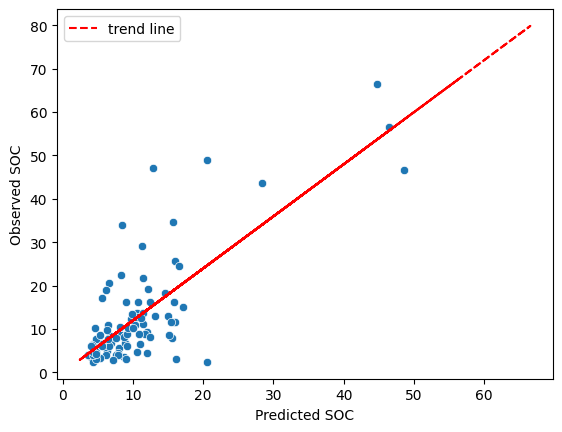

In [89]:
# Plot the predicted SOC against the observed SOC
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

In [ ]:
# Save the trained model
model.save(os.getcwd() + '/LSTM', save_format='tf')

In [ ]:
# Check if the model can be properly loaded
model = tf.keras.models.load_model(os.getcwd() + '/LSTM') 